In [1]:
# Alejandra Mendez - 28/04/2019
# v1.2
#
#  * this program implements hyperoptimization of NLAMVAR parameters in
#     autosctructure code (max=20)
#  * the autovarlambda.f90 subroutine is compiled with f2py and incorporated
#     to this code
#  * the autostructure code is executed using system
#  * the number of configurations defined by 'cfgs' in .yaml is considered
#     in the computation
#  * multiple excited energies can be considered via 'nener'
#  * the number of elements in array 'weight' must be equal
#     to the amount of energies 'nener' considered
#
#  * input variables:
#           cfgs     -- number of configurations to be included in the calculation
#           initer   -- initial number of evaluations (first prior)
#           maxevals -- number of evaluations in minimization
#           modpot   -- optimize model potential (True/False)
#           polpot   -- optimize polarization potential (True/False)
#           pseudo   -- optimize pseudostates (True/False)
#           nlamvar  -- number of lambda parameters to be varied
#           maxlam   -- maximum lambda value
#           minlam   -- minimum lambda value
#           cost     -- type of cost function
#                         ="ener"     : summation of energy er%
#                         ="aki"      : summation of einstein coefficient er%
#                         ="ener+aki" : summation of energy and einstein coefficient er%
#           nener    -- number of states to be considered in minimization (if cost='ener' or 'ener+aki')
#           ntran    -- number of transitions to be considered in minimization (if cost='aki' or 'ener+aki')
#           initmap  -- type of initial sampling
#                         ="random" : random sampling
#                         ="latin"  : latin hypercube sampling
#           iseed    -- sets the seed for random initial calculations
#           gridtype -- grid type
#                         ="continuous"
#           mtype    -- model type
#                         ="GP" : Gaussian Process
#           aftype   -- acquisition function type
#                         ="EI"     : Expected improvement
#                         ="MPI"    : Maximum probability of improvement
#                         ="GP-UCB" : Upper confidence bound
#           afweight -- acquisition weight (float)
#           mfunc    -- minimization function
#                         ="Er"    : sum of weighted relative errros
#                         ="Er**2" : sum of weighted square relative errors
#           minst    -- states to be included in minimization
#                         ="gr+ex" : ground and excited states
#                         ="ex"    : only excited states
#           wi       -- minimization weight
#                         ="eq"  : all elements are weighted equally
#                         ="gi"  : use statistical weight gi=sum 2j+1
#                         ="inp" : read input values (below)
#           weight   -- weight in relative errors (number of elements == nener)
#
#
#  * input files:
#           inpvar_gpyopt.yml       -- input file for .py
#           das_XXCFG               -- autostructure input
#           NIST_*.dat              -- observed data
#                                       * cfgs: configurations
#                                       * terms: energy terms
#                                       * energies: binding and ionization energies
#                                       * lines: transition lines
#           f2py_autovarlambda.f90  -- subroutines for structure optimization
#           SR.*.for                -- subroutines for structure optimization

# Quietly compile autovarlamba.f90
import os
import sys
# os.system('f2py -c -m autovarlambda f2py_autovarlambda.f90 SR.as_inp.for SR.nist_inp.for SR.compare_calc.for')
# print('\n===>>> autovarlambda compiled with f2py <<<===')

# Import other stuff
import numpy as np
import autovarlambda
import time
import yaml
import GPy
import GPyOpt
from numpy.random import seed

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec

import pandas as pd
from scipy.optimize import curve_fit

colors=['k','r','g','b','m','y','c','tab:blue',
        'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']
orb=['1s','2s','2p','3s','3p','3d','4s','4p','4d','4f','5s','5p','5d','5f','5g']
symbs=['o','s','v','^','>','<','o','o','o','o','o','o','o','o','o']

# Input parameters
global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid, initer, ipol
global nlamvar, maxlam, minlam, mfunc, ifun, minst, imin, nener, wi, igi, iseed
global ii, npolvar, initmap, cost, modpot, polpot, pseudo

In [2]:
#########################################################################################################
# Define functions
#########################################################################################################
def lamindex(idxlam):
#    inmx=autovarlambda.lamidxbck.inmx
    inmx=45 # check with NMX form fortran subroutine
    vidxlam=np.zeros(inmx)
    for i in range(len(idxlam)): vidxlam[i]=idxlam[i]
    autovarlambda.lamidxbck.idxlam=vidxlam
    return

def data_input():
    global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid, initer
    global ipol, nlamvar, idxlam, maxlam, minlam, mfunc, ifun, minst, imin, nener
    global ntran, wi, igi, iseed, initmap, cost, modpot, polpot, pseudo
    with open('inpvar_gpyopt.yml', 'r') as stream:
        data_loaded=yaml.load(stream)
    cfgs=data_loaded.get('cfgs')
    initer=data_loaded.get('initer')
    maxevals=data_loaded.get('maxevals')
    modpot=data_loaded.get('modpot')
    polpot=data_loaded.get('polpot')
    pseudo=data_loaded.get('pseudo')
    nlamvar=data_loaded.get('nlamvar')
    idxlam=data_loaded.get('orbs')
    lamindex(idxlam)
    maxlam=data_loaded.get('maxlam')
    minlam=data_loaded.get('minlam')
    cost=data_loaded.get('cost')
    nener=data_loaded.get('nener')
    ntran=data_loaded.get('ntran')
    initmap=data_loaded.get('initmap')
    iseed=data_loaded.get('iseed')
    gridtype=data_loaded.get('gridtype')
    mtype=data_loaded.get('mtype')
    aftype=data_loaded.get('aftype')
    afweight=data_loaded.get('afweight')
    mfunc=data_loaded.get('mfunc')
    minst=data_loaded.get('minst')
    wi=data_loaded.get('wi')

    if cfgs is None: raise ValueError('Error: cfgs not defined.')
    if initer is None: raise ValueError('Error: initer not defined.')
    if maxevals is None: raise ValueError('Error: maxevals not defined.')
    if mtype is None:
        mtype='GP'
        print('Warning: model type not defined. Use default: GP')
#    if mtype!='GP': raise ValueError('Error: '+mtype+' not implemented.')
    if aftype is None:
        aftype='EI'
        print('Warning: acquisition function type not defined. Use default: EI')
    if aftype!='EI' and aftype!='MPI' and aftype!='GP-UCB': raise ValueError('Error: '+aftype+' not implemented.')
    if afweight is None:
        afweight=1.
        print('Warning: acquisition function weight not defined. Use default: 1.')
    if gridtype=='continuous':
        igrid=0
    elif gridtype is None:
        igrid=0
        print('Warning: grid type not defined. Use default: continuous')
    else: raise ValueError('Error: '+gridtype+' not implemented.')
    if nlamvar is None: raise ValueError('Error: nlamvar not defined.')
    if len(idxlam) is None: raise ValueError('Error: orbs not defined.')
    if maxlam is None or minlam is None: raise ValueError('Error: maxlam and/or minlam not defined.')
    if mfunc=='Er':
        ifun=0
    elif mfunc=='Er**2':
        ifun=1
    elif mfunc is None:
        imin=0
        print('Warning: minimization function not defined. Use default: Er ')
    else: raise ValueError('Error: '+mfunc+' not implemented.')
    if minst=='gr+ex':
        imin=0
    elif minst=='ex':
        imin=1
    elif minst is None:
        ifun=0
        print('Warning: states to be minimized not defined. Use default: ground + excited')
    else: raise ValueError('Error: '+minst+' not implemented.')
    if nener is None: raise ValueError('Error: nener not defined.')
    if wi=='eq' or wi=='gi':
        if wi=='eq': igi=0
        if wi=='gi': igi=1
        weight=np.full(nener,1.)
    elif wi=='inp':
        inpweight=data_loaded.get('weight')
        linpw=len(inpweight)
        if linpw<nener: # fill the missing wi with the last input value
            for i in range(linpw,nener):
                inpweight.append(inpweight[linpw-1])
        weight=np.array(listweight)
        if inpweight is None or linpw==0:
            raise ValueError('Error: weight not defined.')
    elif wi is None:
        igi=1
        print('Warning: wi not defined. Use default: eq')
    else: raise ValueError('Error: '+wi+'not implemented.')
    if polpot==True:
        ipol=1
        autovarlambda.polbck.ipol=ipol
    else: ipol=0
    if iseed is None:
        iseed=123456.
        raise ValueError('Warning: iseed = 123456 ')
    if initmap is None:
        initmap='latin'
        raise ValueError('Warning: initmap = latin')
    if cost is None:
        cost='ener'
        raise ValueError('Warning: cost = ener')

def print_input():
    global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid
    global initer, ipol, nlamvar, idxlam, maxlam, minlam, mfunc, ifun, minst
    global imin, nener, wi, igi, iseed, initmap, cost, modpot, pseudo
    print('\n===>>> Input parameters <<<===\n')
    print(' * initial evaluations: '+str(initer))
    print(' * evaluations: '+str(maxevals))
    print(' * number of orbitals varied: '+str(nlamvar))
    print(' * orbitals: ',idxlam)
    print(' * model type: '+mtype)
    print(' * acquisition function type: '+aftype)
    print(' * acquisition function weight: '+str(afweight))
    print(' * grid type: '+gridtype)
    if ifun==0: print(' * minimization function: sum of weighted relative errors')
    if ifun==1: print(' * minimization function: sum of weighted square relative errors')
    if imin==0: print(' * states included in minimization: ground + excited')
    if imin==1: print(' * states included in minimization: excited')
    print(' * weight type: '+wi)
    if ipol==1: print(' * polarization: yes')
    if ipol==0: print(' * polarization: no')
    print(' * iseed: ',iseed)
    print(' * initmap: ',initmap)
    print(' * cost: ',cost)

def atom_name(nzion):
    nzion=abs(nzion)
    atomname=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg']
    nname=len(atomname)
    if nzion>nname: raise ValueError('atomname not defined for Z='+str(nzion))
    for i in range(nname):
        if nzion==i+1: chatom=atomname[i]
    return chatom

def pot_type(nzion):
    if nzion < 0:
        chtype='STO'
    else:
        chtype='TFDA'
    return chtype

def human_format(num):
    magnitude=0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000
    return '%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def def_filename():
    global ncfg, filename,initer
    ncfg=autovarlambda.salgebbck.mxconf
    nzion=autovarlambda.sminimbck.nzion
    chatom=atom_name(nzion)
    chtype=pot_type(nzion)
    cfgs=str(ncfg)+'CFG'+chtype
    idrun=str(initer)+mtype+human_format(maxevals)
    filename=chatom+cfgs+'_'+idrun
    return

def open_fout():
    global fener,fvals
    fener=open(filename+'.out','w')
    fvals=open(filename+'.res','w')
    return

def init_var():
    enere=np.zeros(nener)
    enerc=np.zeros(nener)
    neex=int()
    return enere, enerc, neex

def check_errlog():
    ierr=0
    errlog=os.path.exists('errlog')
    if errlog == True:
        ierr=1
        os.system('rm errlog')
    autovarlambda.errlogbck.ierr=ierr
    return

def print_opt(total,myBopt):
    global fmin,weight,fener,npolvar,initer,maxevals,filename,iseed,nlamvar,cost
    var_best=myBopt.x_opt
    fmin=myBopt.fx_opt
    if fvar=='pol':
        py_runAS_pol(var_best,npolvar)
        xalpha='\n'+17*' '+'alpha = '
        xrho=19*' '+'rho = '
        ii=0
        for i in range(npolvar):
            j=i+ii
            xalpha=xalpha+'{vp['+str(j)+']:.{prec}f}'
            xrho=xrho+'{vp['+str(j+1)+']:.{prec}f}'
            if j<npolvar:
                xalpha=xalpha+' , '
                xrho=xrho+' , '
            ii=ii+1
    if fvar=='lam':
        py_runAS_lam(var_best,nlamvar)
        xlambda='\n'+16*' '+'lambda = '
        for i in range(nlamvar):
            xlambda=xlambda+' {vp['+str(i)+']:.{prec}f} '
    if fvar=='pseudo':
        py_runAS_lam(var_best,nlamvar)
        xlambda='\n'+16*' '+'lambda = '
        for i in range(nlamvar):
            xlambda=xlambda+' {vp['+str(i)+']:.{prec}f} '
        
    if cost=='ener': loss_best,lerp_best,xp_best=loss_sumwE()
    if cost=='aki': loss_best,lerp_best,xp_best=loss_sumaki()
    if cost=='ener+aki':
        lei,lerp_best,xp_best=loss_sumwE()
        laki,lerp_best,xp_best=loss_sumaki()
        loss_best=lei+laki
    if cost=='psdiff': loss_best=loss_pseudo(0,var_best)
        
    print('\n'+4*' '+'Initial iterations = {:5d}'.format(initer),file=fener)
    print(' Number of evaluations = {:5d}'.format(maxevals),file=fener)
    print(11*' '+'Random seed = {:8d}'.format(iseed),file=fener)
    print(12*' '+'Total time = {:.{prec}f} min\n'.format(total,prec=4),file=fener)
    print('-'*80,file=fener)
    print(' Best results:',file=fener)
    print('-'*80,file=fener)
    if fvar=='pol':
        print(xalpha.format(vp=var_best,prec=4),file=fener)
        print(xrho.format(vp=var_best,prec=4),file=fener)
    if fvar=='lam':
        print(xlambda.format(vp=var_best,prec=4),file=fener)
    if loss_best!=fmin:
        print("fx_opt = ",fmin,"\nloss_min = ",loss_best)
        raise ValueError('Error: loss_best!=fmin ')
    print('\n'+12*' '+'total loss = {:12.4f} %'.format(loss_best),file=fener)
    print(12*' '+'best loss = {:12.4f} %'.format(fmin),file=fener)
    autovarlambda.print_ener()
    autovarlambda.print_aki()
    os.system('mv relat_error.dat '+filename+'.erp')
    os.system('mv tmp '+filename+'.das')
    fener.close()
    return

def clean_up():
    os.system('rm das CONFIG.DAT oic ols olg TERMS LEVELS')
    os.system('if [ -f "adasex.in.form" ]; then rm adas* adf* OMG*; fi')

########################################################################
#                             S P A C E S
########################################################################

def lamspace(minlam,maxlam):
    space=[]
    for i in range(nlamvar):
        alam=str(i+1)
#        space.append({'name': 'lam'+alam, 'type': gridtype, 'domain': (minlam,maxlam)})
        space.append({'name': 'lam'+alam, 'type': gridtype, 'domain': (minlam[i],maxlam[i])})
    return space

def polspace(alpha_min,alpha_max,rho_min,rho_max,npolvar):
    space=[]
    for i in range(npolvar):
        apol=str(i)
        space.append({'name': 'alpha'+apol, 'type': 'continuous', 'domain': (alpha_min[i],alpha_max[i])})
        space.append({'name': 'rho'+apol, 'type': 'continuous', 'domain': (rho_min[i],rho_max[i])})
    return space

########################################################################
#                             K E R N E L S
########################################################################

def lamkernel(rbf,stdperiodic):
    if rbf==1: kernel=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
    if rbf==1 and stdperiodic==1:
        kernel1=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
        kernel2=GPy.kern.StdPeriodic(input_dim=nlamvar,variance=varf,period=None,lengthscale=None,ARD1=ARD,ARD2=ARD)
        kernel=kernel1*kernel2
    return kernel

def polkernel(rbf,stdperiodic):
    if rbf==1: kernel=GPy.kern.RBF(input_dim=2*npolvar,variance=varf,lengthscale=lf,ARD=ARD)
    return kernel

In [3]:
########################################################################
#                       C O S T     F U N C T I O N S
########################################################################

def error_relat(valexact,valcomp,neex):
    if valexact == 0.0 or valcomp == 0.0:
        error=5./neex
    else:
        error=abs((valexact-valcomp)/valexact)*100
    return error

def loss_sumwE():
    global imin,fvals
    neex=autovarlambda.eei_ls.ne
    enere=autovarlambda.eicompare.enere
    enerc=autovarlambda.eicompare.enerc
    loss=0.0
    if igi==1: weight=autovarlambda.cei_ls.gic
    if igi==0: weight=autovarlambda.cei_ls.gic*0+1.
    lerp=[]
    xp=' '
    for i in range(imin,neex): # consider ground energy and/or-only excited states
        erp=error_relat(enere[i],enerc[i],neex)
        if ifun==1: erp=erp*erp
        loss=loss + weight[i]*erp
        lerp.append(erp)
        xp=xp+'{erpE['+str(i)+']:.{prec}f} '
    return loss,lerp,xp

def loss_sumaki():
    global imin,ntran,akinorm
    ntrtot=autovarlambda.akicompare.ntrtot
    if ntran>ntrtot: ntran=ntrtot
    vakie=autovarlambda.akicompare.vakie
    vakic=autovarlambda.akicompare.vakic
    facc=autovarlambda.akicompare.vfacce
    loss=0.0
    lerp=[]
    xp=' '
    for i in range(imin,ntran): # consider a certain number of transitions
        erp=error_relat(vakie[i],vakic[i],ntran)
        if akinorm=='yes': erp=erp/facc[i]
        if ifun==1: erp=erp*erp
        loss=loss+erp
        lerp.append(erp)
        xp=xp+'{erpA['+str(i)+']:.{prec}f} '
    return loss,lerp,xp

def loss_total(ii,x):
    global cost
    lx=len(x)
    xp='{:4d}: [ '
    for i in range(lx):
        xp=xp+'{vp['+str(i)+']:.{prec}f} '
    xp=xp+'] // {l1:.{prec}f}'
    if cost=='ener':
        lei,lerp,xperp=loss_sumwE()
        xperp=' {} '+xperp
        loss=lei
#        print(xp.format(ii,vp=x,l1=lei,prec=4),file=fener)
        print(xp.format(ii,vp=x,l1=lei,prec=4))
        print(xperp.format(loss,erpE=lerp,prec=4),file=fvals)
    if cost=='aki':
        laki,lerp,xperp=loss_sumaki()
        xperp=' {} '+xperp
        loss=laki
#        print(xp.format(ii,vp=x,l1=lei,l2=laki,lt=loss,prec=4),file=fener)
        print(xp.format(ii,vp=x,l1=laki,lt=loss,prec=4))
        print(xperp.format(loss,erpA=lerp,prec=4),file=fvals)
    if cost=='ener+aki':
        lei,lerpE,xpE=loss_sumwE()
        laki,lerpA,xpA=loss_sumaki()
        xperp=' {} '+xpE+xpA
        loss=lei+laki
        xp=xp+' + {l2:.{prec}e} = {lt:.{prec}e}'
#        print(xp.format(ii,vp=x,l1=lei,l2=laki,lt=loss,prec=4),file=fener)
        print(xp.format(ii,vp=x,l1=lei,l2=laki,lt=loss,prec=4))
        print(xperp.format(loss,erpE=lerpE,erpA=lerpA,prec=4),file=fvals)
    return loss

def multiplicity_separation():
    global nbins,inips_cfg
    cterms=pd.read_csv('TERMS',header='infer',sep='\s+')
    nrows=len(cterms)-1
    cterms.drop(nrows,axis=0,inplace=True)
#     for i in range(nrows):
#         if cterms.loc[i]['CF']<inips_cfg: cterms.drop(i,axis=0,inplace=True)
#     cterms.reset_index(drop=True,inplace=True)
    nrows=len(cterms)
    sing_cterms=cterms.copy()
    trip_cterms=cterms.copy()
    for i in range(nrows):
        if cterms.loc[i]['S']==1: trip_cterms.drop(i,axis=0,inplace=True)
        if cterms.iloc[i]['S']==3: sing_cterms.drop(i,axis=0,inplace=True)
        if cterms.iloc[i]['S']==2: 
            print("2S+1==2 not implemented yet")
            sys.exit()
    return sing_cterms,trip_cterms

def hist2scatt(bins):
    nbins=len(bins)
    dele=(bins[1]-bins[0])/2.
#     print(dele)
    ctr=[]
    for i in range(nbins-1):
        ctr.append(bins[i]+dele)
    return np.array(ctr)

def plot_all(sing_cterms,sing_ctr,sing_counts,trip_cterms,trip_ctr,trip_counts,xp,gfun,sing_gfit,trip_gfit):
    global eion,ngauss,nbins,bins,fmax
    global emin,emax
    fig=plt.figure(figsize=(6.4*2, 4.8))
    
    ax1=plt.subplot(121)
    plt.axvline(x=eion,linestyle='dashed', color='tab:gray')
    plt.hist(sing_cterms['ENERGY(RYD)'],bins=bins,color='g',label='singlet')
    plt.plot(sing_ctr,sing_counts,'ro')
    plt.plot(xp,sing_gfit,'r--')
    plt.plot(xp,gfun,'k')
    plt.legend(loc='best')
    plt.ylim(0,fmax)
    plt.xlim(emin,emax)

    ax2=plt.subplot(122)
    plt.axvline(x=eion,linestyle='dashed', color='tab:gray')
    plt.hist(trip_cterms['ENERGY(RYD)'],bins=bins,color='r',label='triplet')
    plt.plot(trip_ctr,trip_counts,'go')
    plt.plot(xp,trip_gfit,'g--')
    plt.plot(xp,gfun,'k')
    plt.legend(loc='best')
    plt.ylim(0,fmax)
    plt.xlim(emin,emax)
    plt.show()    
    return

def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x,A1,mu1,sigma1,A2,mu2,sigma2):
    return gauss(x,A1,mu1,sigma1)+gauss(x,A2,mu2,sigma2)

def fexp(xp,A,x0,alpha):
    return A*np.exp(-(xp-x0)*alpha)

def gaussexp(xp,A1,mu1,sigma1,A2,alpha):
#     y=gauss(xp,A1,mu1,sigma1)
    n=len(xp)
    y=np.zeros(n)
    for i in range(n):
        if xp[i]<=mu1: y[i]=gauss(xp[i],A1,mu1,sigma1)
        if xp[i]>mu1: y[i]=fexp(xp[i],A1,mu1,alpha)
    return y

def multigauss(x,*arg):
    y=0
    for i in range(ngauss):
        ii=3*(i-1)
        y=y+gauss(x,arg[ii],arg[ii+1],arg[ii+2])
    return y

def fit_gauss(x,y):
    global ngauss
    maxgauss=10
    for ngauss in range(3,maxgauss):
        p0=np.zeros(3*ngauss)+1
        popt=np.zeros(3*ngauss)
        try: 
            popt,pcov=curve_fit(multigauss,x,y,p0=p0,maxfev=10000)
            break
        except:
            if ngauss==maxgauss-1: print('increase maxgauss')
            continue
    return popt

def integrate_rk(x,y,k):
    yk=y*y*x**k
    return np.trapz(yk,x=x)

def diff_density(x,y,xp,gfun):
    Nterms=sum(y)
    print(" ")
    print("Nterms=",Nterms)
    popt=fit_gauss(x,y)
    gfit=multigauss(xp,*popt)
    gfit_norm=integrate_rk(xp,gfit,0)
    print("Gfit=",gfit_norm)
    # normalize gfun
    gfun_norm=integrate_rk(xp,gfun,0)
    print("Gfun=",gfun_norm)
    gfit=gfit/np.sqrt(gfit_norm)
    gfun=gfun/np.sqrt(gfun_norm)
    gfit_norm=integrate_rk(xp,gfit,0)
    gfun_norm=integrate_rk(xp,gfun,0)
    print("new Gfit=",gfit_norm)
    print("new Gfun=",gfun_norm)
    gdiff=(gfun-gfit)
    diffint=integrate_rk(xp,gdiff,0)
    return diffint,gfit

def loss_pseudo(ii,x):
    global nbins,bins,xp,gfun
    global eion,ngauss,sing_gfit,trip_gfit
    sing_cterms,trip_cterms=multiplicity_separation()
    sing_counts,sing_bins=np.histogram(sing_cterms['ENERGY(RYD)'],bins=bins)
    trip_counts,trip_bins=np.histogram(trip_cterms['ENERGY(RYD)'],bins=bins)
    sing_ctr=hist2scatt(sing_bins)
    trip_ctr=hist2scatt(trip_bins)
    intsing,sing_gfit=diff_density(sing_ctr,sing_counts,xp,gfun)
    inttrip,trip_gfit=diff_density(trip_ctr,trip_counts,xp,gfun)
    plot_all(sing_cterms,sing_ctr,sing_counts,trip_cterms,trip_ctr,trip_counts,xp,gfun,sing_gfit,trip_gfit)
    loss=intsing+inttrip
    print(ii,x,loss)
    return loss

In [4]:
########################################################################
#                           F U N C T I O N S
########################################################################

def py_runAS_lam(lam,nlamvar):
    check_errlog()
    autovarlambda.run_varlam(lam,nlamvar)
    check_errlog()
    autovarlambda.inp_comp()
    autovarlambda.compare_ei()
    autovarlambda.compare_aki()
    return

def py_runAS_pol(pol,npolvar):
    check_errlog()
    autovarlambda.run_varpol(pol,npolvar)
    check_errlog()
    autovarlambda.inp_comp()
    autovarlambda.compare_ei()
    autovarlambda.compare_aki()
    return

def var_lam(x):
    global ii
    ii=ii+1
    lam=x[0,:]
    py_runAS_lam(lam,nlamvar)
    loss=loss_total(ii,lam)
#    print(lam,loss)
    return loss

def var_pseudo(x):
    global ii
    ii=ii+1
    lam=x[0,:]
    py_runAS_lam(lam,nlamvar)
#     loss=loss_total(ii,lam)
    loss=loss_pseudo(ii,lam)
    return loss

def var_pol(x):
    global ii,npolvar
    pol=x[0,:]
    ii=ii+1
    py_runAS_pol(pol,npolvar)
    loss=loss_total(ii,pol)
    return loss

def run_bo(iseed,space,kernel,function,initer,initmap,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi):
    seed(iseed)
    enere, enerc, neex=init_var()
    cpdas='cp das_' + str(cfgs) + 'CFG das'
    os.system(cpdas)
    autovarlambda.open_files()
    autovarlambda.inp_das()
    autovarlambda.inp_obs()
    dummyne=autovarlambda.eei_ls.ne.copy()
    if nener != dummyne:
        autovarlambda.eei_ls.ne=nener
    def_filename()
    if ncfg != cfgs:
        print(' >>>> configuration mismatch !!!! ')
        sys.exit()
    open_fout()
    t0=time.time()
    global ii
    ii=0
    model=GPyOpt.models.GPModel(kernel=kernel,noise_var=noise_var,exact_feval=exact_feval,
                                optimizer='lbfgs',max_iters=1500,optimize_restarts=optimize_restarts,
                                verbose=False,ARD=ARD)
    dspace=GPyOpt.Design_space(space=space)
    objective=GPyOpt.core.task.SingleObjective(function)
    initial_design=GPyOpt.experiment_design.initial_design(initmap,dspace,initer)
    acquisition_optimizer=GPyOpt.optimization.AcquisitionOptimizer(dspace, optimizer='lbfgs')
    acquisition=GPyOpt.acquisitions.AcquisitionEI(model,dspace,acquisition_optimizer,jitter=xi)
    evaluator=GPyOpt.core.evaluators.Sequential(acquisition)
    myBopt=GPyOpt.methods.ModularBayesianOptimization(model,dspace,objective,acquisition,
                                                      evaluator,X_init=initial_design,normalize_Y=True,
                                                      model_update_interval=1)
    myBopt.run_optimization(maxevals,eps=1e-7,verbosity=False)
    myBopt.save_evaluations(filename+'.dat')
    t1=time.time()
    total=(t1-t0)/60.
    print_opt(total,myBopt)
    return


===>>> Optimize Pseudostates <<<===


 * cost =  psdiff
 
Nterms= 15
Gfit= 4.241104490664494
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 1.2111245439356419e-67
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997


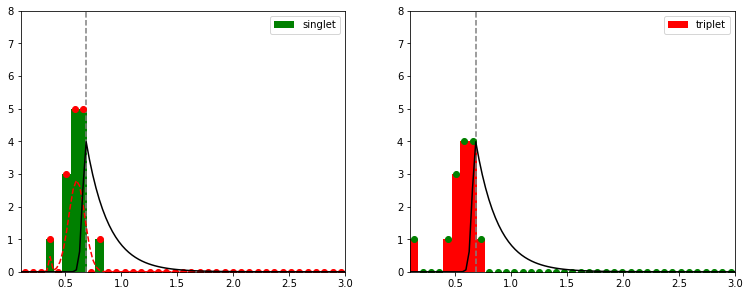

1 [0.53 0.59 0.77 0.65 0.53] 4.10463762949648
 
Nterms= 15
Gfit= 7.437604391170341e-40
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 3.929533730462879
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997


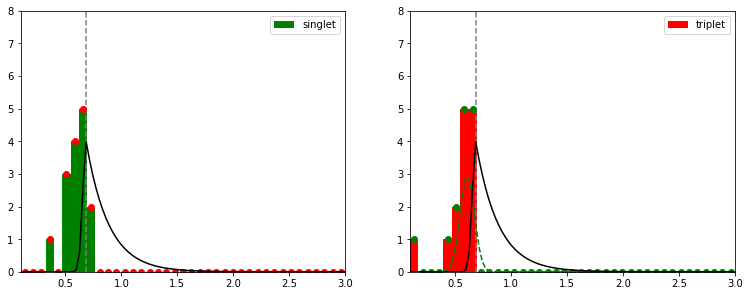

2 [0.77 0.65 0.59 0.59 0.65] 4.239279951725236
 
Nterms= 15
Gfit= 2.705543057648242e-42
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 3.488228716919914
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997


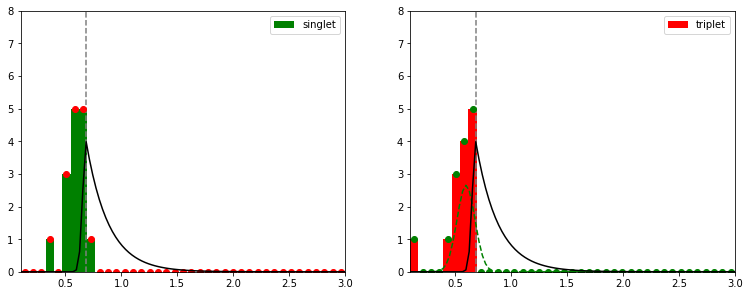

3 [0.65 0.53 0.53 0.71 0.77] 4.1965286928158765
 
Nterms= 15
Gfit= 3.6254135789136863
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 3.4579697865026224
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997


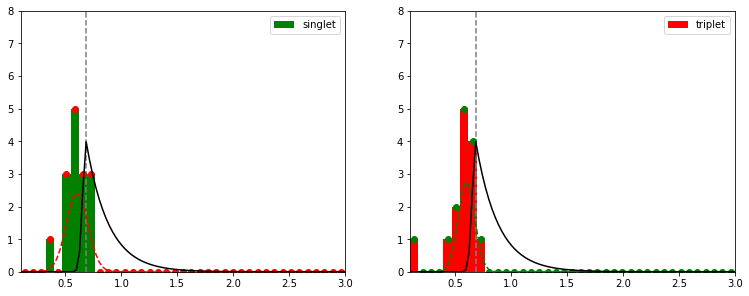

4 [0.71 0.77 0.65 0.53 0.71] 2.299460751824393
 
Nterms= 15
Gfit= 3.1600805179347815
Gfun= 2.0335074064519763
new Gfit= 1.0
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 411.71863099134043
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997


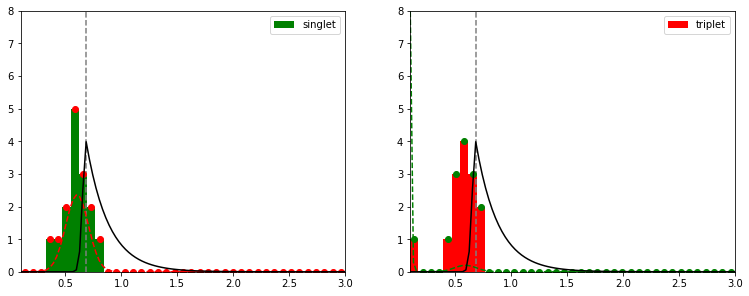

5 [0.59 0.71 0.71 0.77 0.59] 2.9538282465077095
 
Nterms= 15
Gfit= 3.6254135789136863
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997
 
Nterms= 14
Gfit= 3.4579697865026224
Gfun= 2.0335074064519763
new Gfit= 1.0000000000000002
new Gfun= 0.9999999999999997


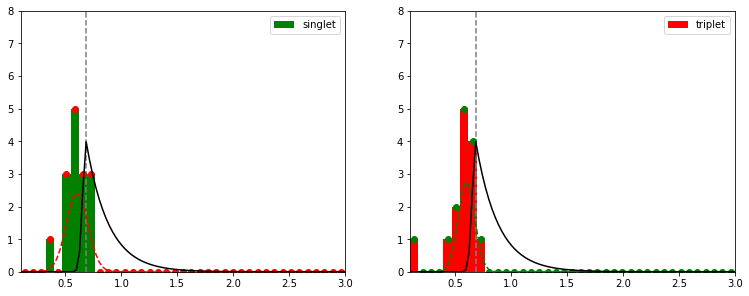

0 [0.71 0.77 0.65 0.53 0.71] 2.299460751824393


In [9]:
########################################################################
#                        M A I N    P R O G R A M
########################################################################

# call input data
data_input()
# print_input()

# other important variables
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=afweight # input
optimize_restarts=5
#minlam=[]
#maxlam=[]

################################
#    POLARIZATION POTENTIAL    #
################################
if polpot==True:
    print('\n===>>> Optimize Polarization Potential <<<===\n')
    print('\n * cost = ',cost)
    # define values for the polarization parameters' space
    alpha_max=[0.200,0.200,0.200]
    alpha_min=[0.001,0.001,0.001]
    rho_max=[1.500,1.500,1.500]
    rho_min=[0.200,0.200,0.200]
    npolvar=3
    if npolvar != len(alpha_min):
        print('npolvar .ne. alpha and rho dimension')

    fvar='pol'
    space=polspace(alpha_min,alpha_max,rho_min,rho_max,npolvar)
    kernel=polkernel(rbf=1,stdperiodic=0)
    run_bo(iseed,space,kernel,var_pol,initer,initmap,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
    os.system('cp Be*.das das_6CFG')
    os.system('if [ ! -d pol ]; then mkdir pol; fi')
    os.system('mv Be* pol/.')

################################
#       MODEL POTENTIAL        #
################################
if modpot==True:
    print('\n===>>> Optimize Model Potential <<<===\n')
    print('\n * cost = ',cost)
    fvar='lam'
    akinorm='yes'  # normalizar los errores relativos de Aki
    space=lamspace(minlam,maxlam)
    kernel=lamkernel(rbf=1,stdperiodic=0)
    run_bo(iseed,space,kernel,var_lam,initer,initmap,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)

################################
#       PSEUDO ORBITALS        #
################################
if pseudo==True:
    global xp,gfun,eion,nbins,bins,fmax
    global emin,emax
    print('\n===>>> Optimize Pseudostates <<<===\n')
    cost='psdiff'  # minimiza la diferencia entre las pseudoenergias y la energía de ionización
    print('\n * cost = ',cost)
    fvar='pseudo'
    
    inips_cfg=7
    nbins=40
    emin=0.1
    emax=3.0
    fmax=8
    bins=np.linspace(emin,emax,nbins)
    eion=autovarlambda.eion.eion
    xp=np.linspace(emin,emax,100)
    A1=4
    mu1=eion
    sigma1=0.03
    A2=1
    mu2=0.9
    sigma2=0.2
    alpha=5
#     gfun=bimodal(xp,A1,mu1,sigma1,A2,mu2,sigma2)
    gfun=gaussexp(xp,A1,mu1,sigma1,A2,alpha)
    
    space=lamspace(minlam,maxlam)
    kernel=lamkernel(rbf=1,stdperiodic=0)
    run_bo(iseed,space,kernel,var_pseudo,initer,initmap,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)

# clean_up()

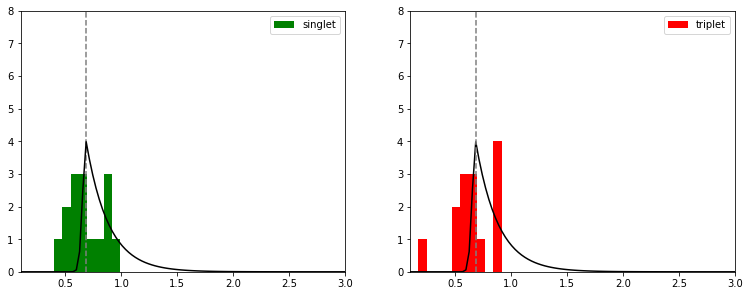

In [8]:
cterms=pd.read_csv('novar/TERMS',header='infer',sep='\s+')
inips_cfg=7
nrows=len(cterms)-1
cterms.drop(nrows,axis=0,inplace=True)
# for i in range(nrows):
#     if cterms.loc[i]['CF']<inips_cfg: cterms.drop(i,axis=0,inplace=True)
# cterms.reset_index(drop=True,inplace=True)
nrows=len(cterms)
sing_cterms=cterms.copy()
trip_cterms=cterms.copy()
# sing_cterms,trip_cterms=multiplicity_separation()
for i in range(nrows):
    if cterms.loc[i]['S']==1: trip_cterms.drop(i,axis=0,inplace=True)
    if cterms.iloc[i]['S']==3: sing_cterms.drop(i,axis=0,inplace=True)
    if cterms.iloc[i]['S']==2: 
        print("2S+1==2 not implemented yet")
        sys.exit()

fig=plt.figure(figsize=(6.4*2, 4.8))
ax1=plt.subplot(121)
plt.hist(sing_cterms['ENERGY(RYD)'],bins=bins,color='g',label='singlet')
plt.axvline(x=eion,linestyle='dashed', color='tab:gray')
# plt.plot(xp,sing_gfit,'r--')
plt.plot(xp,gfun,'k')
plt.legend(loc='best')
plt.ylim(0,fmax)
plt.xlim(emin,emax)

ax2=plt.subplot(122)
plt.hist(trip_cterms['ENERGY(RYD)'],bins=bins,color='r',label='triplet')
# plt.plot(xp,trip_gfit,'r--')
plt.plot(xp,gfun,'k')
plt.axvline(x=eion,linestyle='dashed', color='tab:gray')
plt.legend(loc='best')
plt.ylim(0,fmax)
plt.xlim(emin,emax)

plt.show()